# Analysis of Environment Aloft

This notebook analyzes the environment above clouds at their birth time, relating it to cloud lifetime and maximum height.
We focus on full lifecycle clouds (no merges/splits) and examine how the environment aloft (RH, moisture, stability, shear) correlates with cloud development.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

# Plotting style
sns.set_context("talk")
sns.set_style("ticks")

# Constants
nc_file = "../cloud_results.nc"
dt = 60.0  # seconds per timestep
dz = 25.0  # meters (vertical grid spacing)

# --- Filtering Configuration ---
min_lifetime_mins = 2       # Minimum lifetime in minutes
filter_mergers_splits = False # If True, exclude clouds that merge or split (isolated only)
min_max_size = 0             # Minimum max size (voxels) required for a track

min_lifetime_steps = int(min_lifetime_mins * 60 / dt)
# Ensure at least 1 step to avoid indexing errors
if min_lifetime_steps < 1:
    min_lifetime_steps = 1

print(f"Minimum lifetime steps: {min_lifetime_steps}")
print(f"Filter Mergers/Splits: {filter_mergers_splits}")
print(f"Minimum Max Size: {min_max_size}")

Minimum lifetime steps: 2
Filter Mergers/Splits: False
Minimum Max Size: 0


### Data Loading
**Physics:** Loads tracks and environmental profiles (RH, $N^2$, shear) from the column directly above cloud top at birth.

In [4]:
def load_data(nc_path):
    with Dataset(nc_path, 'r') as ds:
        # Load track info
        valid_track = ds.variables['valid_track'][:]
        merges_count = np.ma.filled(ds.variables['merges_count'][:], 0)
        splits_count = np.ma.filled(ds.variables['splits_count'][:], 0)
        
        # Load cloud properties
        size = np.ma.filled(ds.variables['size'][:], np.nan)
        max_height = np.ma.filled(ds.variables['max_height'][:], np.nan)
        
        # Load age variable for lifetime calculation
        # Shape: (track, time)
        # Use -1 as fill value for integer array, then convert to float/nan if needed
        age_raw = ds.variables['age'][:]
        age = np.ma.filled(age_raw, -1)
        
        # Load environment aloft variables
        # Shape: (track, time, height_aloft)
        env_aloft_rh = np.ma.filled(ds.variables['env_aloft_rh'][:], np.nan)
        env_aloft_qt_diff = np.ma.filled(ds.variables['env_aloft_qt_diff'][:], np.nan)
        env_aloft_n2 = np.ma.filled(ds.variables['env_aloft_n2'][:], np.nan)
        env_aloft_shear = np.ma.filled(ds.variables['env_aloft_shear'][:], np.nan)

        # Load environment aloft variability (std)
        # Check if variables exist (for backward compatibility)
        if 'env_aloft_rh_std' in ds.variables:
            env_aloft_rh_std = np.ma.filled(ds.variables['env_aloft_rh_std'][:], np.nan)
            env_aloft_qt_std = np.ma.filled(ds.variables['env_aloft_qt_std'][:], np.nan)
            env_aloft_n2_std = np.ma.filled(ds.variables['env_aloft_n2_std'][:], np.nan)
            env_aloft_shear_std = np.ma.filled(ds.variables['env_aloft_shear_std'][:], np.nan)
        else:
            # Fallback if variables don't exist
            shape = env_aloft_rh.shape
            env_aloft_rh_std = np.full(shape, np.nan)
            env_aloft_qt_std = np.full(shape, np.nan)
            env_aloft_n2_std = np.full(shape, np.nan)
            env_aloft_shear_std = np.full(shape, np.nan)
        
    return {
        'valid_track': valid_track,
        'merges_count': merges_count,
        'splits_count': splits_count,
        'size': size,
        'max_height': max_height,
        'age': age,
        'env_aloft_rh': env_aloft_rh,
        'env_aloft_qt_diff': env_aloft_qt_diff,
        'env_aloft_n2': env_aloft_n2,
        'env_aloft_shear': env_aloft_shear,
        'env_aloft_rh_std': env_aloft_rh_std,
        'env_aloft_qt_std': env_aloft_qt_std,
        'env_aloft_n2_std': env_aloft_n2_std,
        'env_aloft_shear_std': env_aloft_shear_std
    }

data = load_data(nc_file)
print("Data loaded.")

Data loaded.


### Data Filtering
**Physics:** Filters the dataset based on lifecycle properties.
*   **Valid Track:** Always requires a complete lifecycle (start to finish recorded, no edge artifacts).
*   **Mergers/Splits:** Configurable. Can restrict to isolated clouds (no interaction) or include complex tracks.
*   **Size/Duration:** Filters for minimum development to remove noise.

In [5]:
# Filter Data

# 1. Calculate lifetime using the 'age' variable
# The 'age' variable tracks the age of the cloud at each timestep.
# The maximum age reached by a track represents its total lifetime.
# Note: age is in timesteps (0-based index).
# Convert -1 (fill value) to NaN for calculation or just use max ignoring -1
age_float = data['age'].astype(float)
age_float[data['age'] == -1] = np.nan
max_age_steps = np.nanmax(age_float, axis=1)

# Lifetime in minutes = (max_age_steps + 1) * dt / 60.0
# Because age starts at 0. If max_age is 0, it lived for 1 step (dt seconds).
lifetime_mins = (max_age_steps + 1) * dt / 60.0
lifetime_steps = (max_age_steps + 1).astype(int)

# 2. Identify birth time (first index where size is not NaN)
# We can use argmax on the boolean mask ~np.isnan(size) to find the first True
# Note: For tracks with all NaNs (lifetime=0), argmax returns 0. These are filtered out by min_lifetime.
birth_indices = np.argmax(~np.isnan(data['size']), axis=1)

# 3. Calculate Max Size per track
# Used for size filtering
max_size_per_track = np.nanmax(data['size'], axis=1)

# 4. Construct Filter Masks

# A. Valid track (complete lifecycle, not tainted by domain edges)
is_valid = data['valid_track'] == 1

# B. Merger/Split Filter
# If filter_mergers_splits is True, we require 0 merges and 0 splits.
# Otherwise, we allow them (mask is all True).
if filter_mergers_splits:
    no_merges = np.sum(data['merges_count'], axis=1) == 0
    no_splits = np.sum(data['splits_count'], axis=1) == 0
    interaction_mask = no_merges & no_splits
else:
    interaction_mask = np.ones_like(is_valid, dtype=bool)

# C. Minimum Lifetime
long_enough = lifetime_steps >= min_lifetime_steps

# D. Minimum Size
big_enough = max_size_per_track >= min_max_size

# Combine all masks
clean_mask = is_valid & interaction_mask & long_enough & big_enough

print(f"Total tracks: {len(lifetime_steps)}")
print(f"  - Valid (full lifecycle): {np.sum(is_valid)}")
print(f"  - Interaction Filter (Pure={filter_mergers_splits}): {np.sum(interaction_mask)}")
print(f"  - Duration >= {min_lifetime_mins} min: {np.sum(long_enough)}")
print(f"  - Size >= {min_max_size}: {np.sum(big_enough)}")
print(f"Final clean selection: {np.sum(clean_mask)}")

# Apply mask
selected_indices = np.where(clean_mask)[0]

# Define n_levels and z_above globally for this cell
n_levels = data['env_aloft_rh'].shape[2]
z_above = (np.arange(n_levels) + 1) * dz

# Check if we have any selected clouds
if len(selected_indices) == 0:
    print("WARNING: No clouds selected! Adjust filters.")
    # Create empty arrays to avoid errors in subsequent cells
    sel_lifetime_mins = np.array([])
    sel_max_height = np.array([])
    sel_env_rh = np.zeros((0, n_levels))
    sel_env_qt = np.zeros((0, n_levels))
    sel_env_n2 = np.zeros((0, n_levels))
    sel_env_shear = np.zeros((0, n_levels))
    
    sel_env_rh_std = np.zeros((0, n_levels))
    sel_env_qt_std = np.zeros((0, n_levels))
    sel_env_n2_std = np.zeros((0, n_levels))
    sel_env_shear_std = np.zeros((0, n_levels))
else:
    # Extract birth-time profiles for selected clouds
    # We need to index (track, time, height_aloft)
    # Advanced indexing: data[track_idx, birth_time_idx, :]

    birth_times = birth_indices[selected_indices]

    # Extract variables
    sel_lifetime_mins = lifetime_mins[selected_indices]
    # Max height is time-dependent, we want the max over the lifetime
    # max_height variable in NC is (track, time). We want the global max for each track.
    sel_max_height = np.nanmax(data['max_height'][selected_indices], axis=1)

    # Extract profiles
    # Shape: (N_selected, N_levels)
    # Extract the environment at the moment of birth.
    # 'birth_times' contains the time index of the first valid cloud size for each selected track.
    sel_env_rh = data['env_aloft_rh'][selected_indices, birth_times, :]
    sel_env_qt = data['env_aloft_qt_diff'][selected_indices, birth_times, :]
    sel_env_n2 = data['env_aloft_n2'][selected_indices, birth_times, :]
    sel_env_shear = data['env_aloft_shear'][selected_indices, birth_times, :]

    # Extract std
    sel_env_rh_std = data['env_aloft_rh_std'][selected_indices, birth_times, :]
    sel_env_qt_std = data['env_aloft_qt_std'][selected_indices, birth_times, :]
    sel_env_n2_std = data['env_aloft_n2_std'][selected_indices, birth_times, :]
    sel_env_shear_std = data['env_aloft_shear_std'][selected_indices, birth_times, :]

    print(f"Extracted profiles for {len(selected_indices)} clouds.")
    print(f"z_above levels: {z_above}")

Total tracks: 100000
  - Valid (full lifecycle): 99602
  - Interaction Filter (Pure=False): 100000
  - Duration >= 2 min: 1881
  - Size >= 0: 3621
Final clean selection: 1669
Extracted profiles for 1669 clouds.
z_above levels: [  25.   50.   75.  100.  125.  150.  175.  200.  225.  250.  275.  300.
  325.  350.  375.  400.  425.  450.  475.  500.  525.  550.  575.  600.
  625.  650.  675.  700.  725.  750.  775.  800.  825.  850.  875.  900.
  925.  950.  975. 1000. 1025. 1050. 1075. 1100. 1125. 1150. 1175. 1200.
 1225. 1250. 1275. 1300. 1325. 1350. 1375. 1400. 1425. 1450. 1475. 1500.
 1525. 1550. 1575. 1600. 1625. 1650. 1675. 1700. 1725. 1750. 1775. 1800.
 1825. 1850. 1875. 1900. 1925. 1950. 1975. 2000. 2025. 2050. 2075. 2100.
 2125. 2150. 2175. 2200. 2225. 2250. 2275. 2300. 2325. 2350. 2375. 2400.
 2425. 2450. 2475. 2500. 2525. 2550. 2575. 2600. 2625. 2650. 2675. 2700.
 2725. 2750. 2775. 2800. 2825. 2850. 2875. 2900. 2925. 2950. 2975. 3000.
 3025. 3050. 3075. 3100. 3125. 3150. 3175. 

/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_43999/1975538318.py:10: RuntimeWarning: All-NaN slice encountered
  max_age_steps = np.nanmax(age_float, axis=1)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_43999/1975538318.py:15: RuntimeWarning: invalid value encountered in cast
  lifetime_steps = (max_age_steps + 1).astype(int)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_43999/1975538318.py:24: RuntimeWarning: All-NaN slice encountered
  max_size_per_track = np.nanmax(data['size'], axis=1)


--- Plot: Vertical Profiles for 3 Random Clouds ---


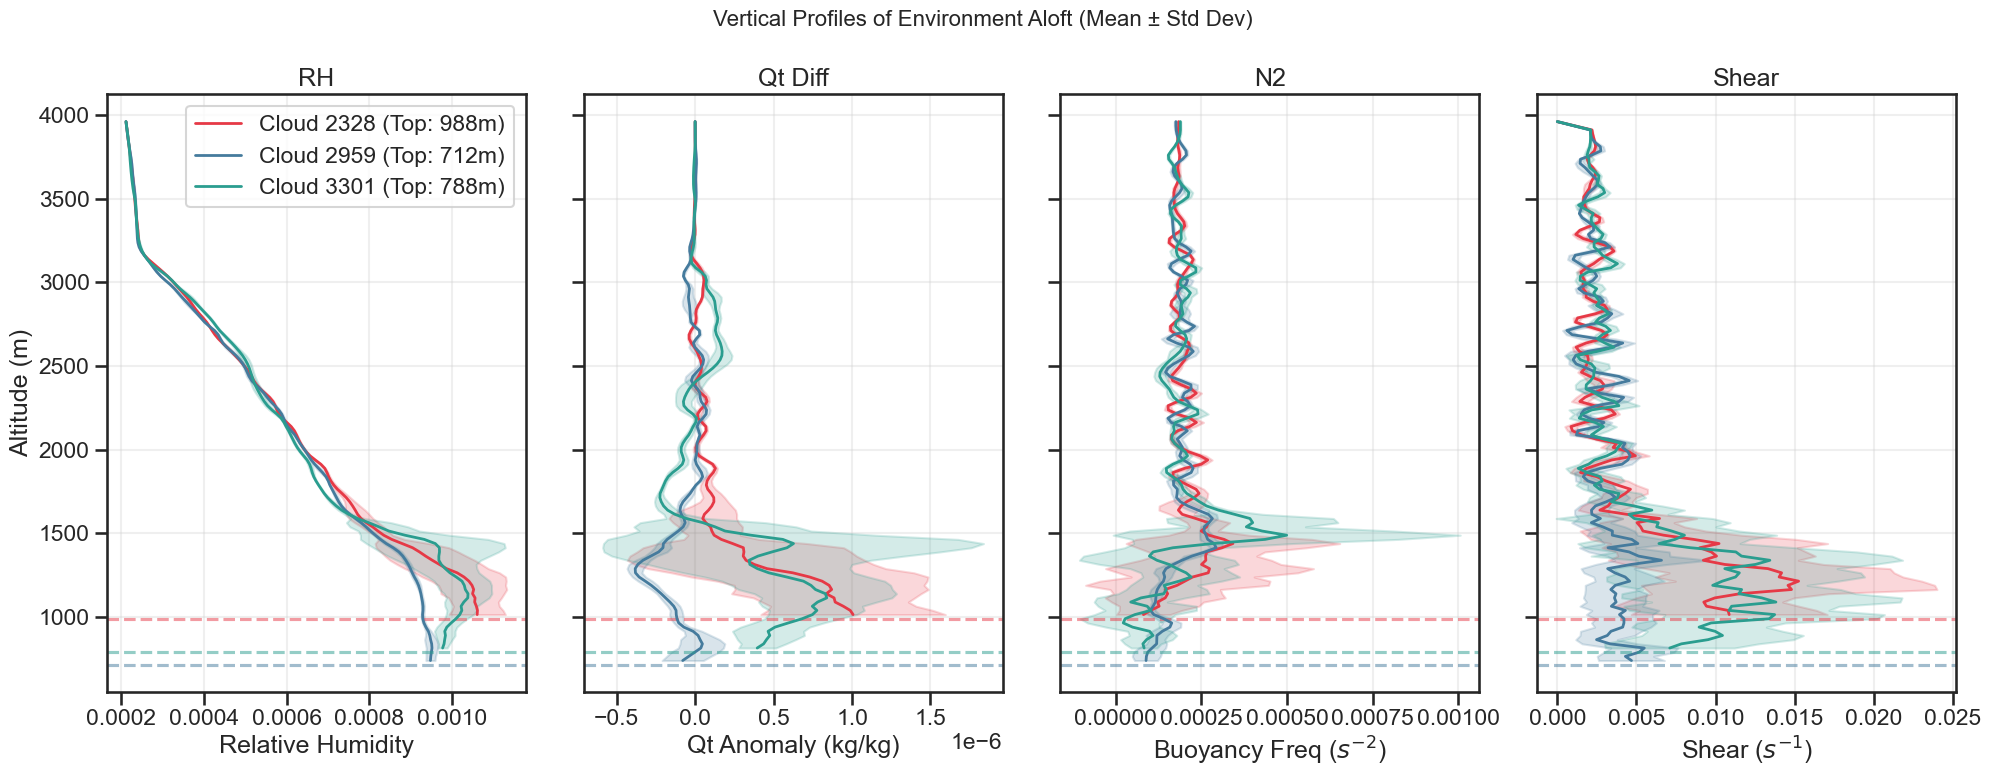

In [6]:
# --- Plot: Vertical Profiles for 3 Random Clouds ---
print("--- Plot: Vertical Profiles for 3 Random Clouds ---")

if len(selected_indices) < 3:
    print(f"Not enough clouds selected (N={len(selected_indices)}). Need at least 3.")
else:
    # 1. Select 3 random clouds
    # We select indices into the 'selected_indices' array
    rng = np.random.default_rng()
    rand_idxs = rng.choice(len(selected_indices), 3, replace=False)
    
    # 2. Get Cloud Top Heights at Birth
    # We need to go back to the full 'data' dictionary to get max_height at the specific birth time
    # selected_indices[rand_idxs] gives the track indices
    # birth_times[rand_idxs] gives the time indices
    
    sel_track_idxs = selected_indices[rand_idxs]
    sel_birth_times = birth_times[rand_idxs]
    
    # Extract birth heights
    birth_heights = data['max_height'][sel_track_idxs, sel_birth_times]
    
    # 3. Plot
    fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
    colors = ['#E63946', '#457B9D', '#2A9D8F'] # Nice colors
    
    vars_to_plot = [
        (sel_env_rh, sel_env_rh_std, 'Relative Humidity', 'RH'),
        (sel_env_qt, sel_env_qt_std, 'Qt Anomaly (kg/kg)', 'Qt Diff'),
        (sel_env_n2, sel_env_n2_std, 'Buoyancy Freq ($s^{-2}$)', 'N2'),
        (sel_env_shear, sel_env_shear_std, 'Shear ($s^{-1}$)', 'Shear')
    ]
    
    for i, (data_array, std_array, xlabel, title) in enumerate(vars_to_plot):
        ax = axes[i]
        
        for k, idx in enumerate(rand_idxs):
            # Get profile for this cloud
            # data_array is already subsetted to (N_selected, n_levels)
            profile = data_array[idx, :]
            std_profile = std_array[idx, :]
            
            # Calculate Absolute Altitude Axis
            # z_above is relative to cloud top. 
            # z_abs = cloud_top + z_above
            z_abs = birth_heights[k] + z_above
            
            # Plot Mean
            label = f"Cloud {sel_track_idxs[k]} (Top: {birth_heights[k]:.0f}m)" if i == 0 else None
            ax.plot(profile, z_abs, color=colors[k], linewidth=2, label=label)
            
            # Plot Std Dev (Shading)
            ax.fill_betweenx(z_abs, profile - std_profile, profile + std_profile, color=colors[k], alpha=0.2)
            
            # Mark Cloud Top
            ax.axhline(birth_heights[k], color=colors[k], linestyle='--', alpha=0.5)
            
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        if i == 0:
            ax.set_ylabel("Altitude (m)")
            ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        
    plt.suptitle("Vertical Profiles of Environment Aloft (Mean ± Std Dev)", fontsize=16)
    plt.tight_layout()
    plt.show()

### Profiles vs. Lifetime
**Physics:** Checks for pre-conditioning. Do longer-lived shallow cumuli form under moister, less stable, or lower-shear conditions aloft?

--- Plot 1: Profiles conditioned on Lifetime (Total N=1669) ---


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_43999/980535038.py:55: RuntimeWarning: Mean of empty slice
  mean_prof = np.nanmean(subset, axis=0)
/Users/jure/PhD/coding/tracking/cloudtracker/ct_venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


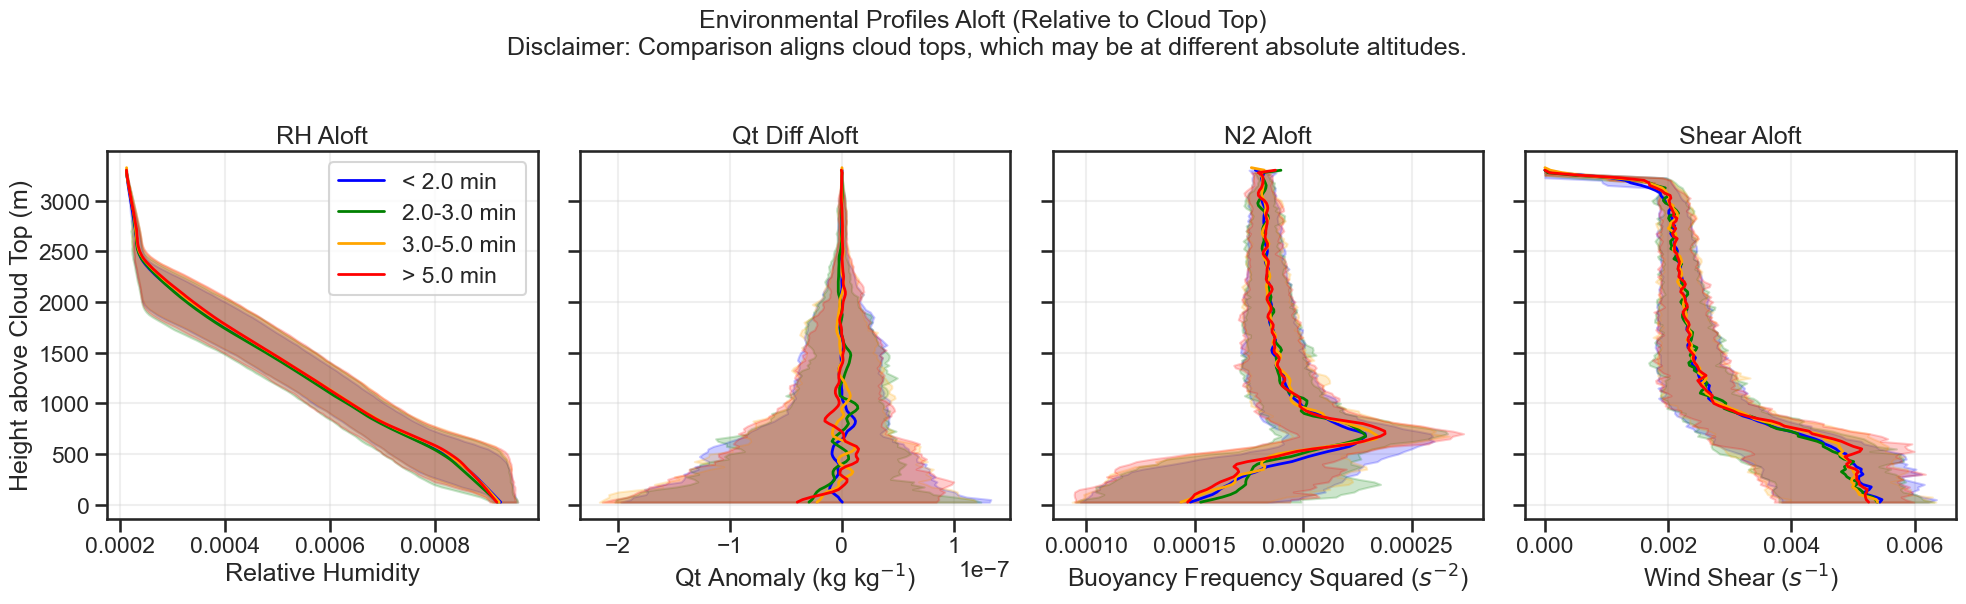

In [7]:
# --- Plot 1: Profiles conditioned on Lifetime ---

if len(sel_lifetime_mins) == 0:
    print("No clouds selected. Skipping plot.")
else:
    print(f"--- Plot 1: Profiles conditioned on Lifetime (Total N={len(sel_lifetime_mins)}) ---")

# Define groups by quartiles
q1 = np.percentile(sel_lifetime_mins, 25)
q2 = np.percentile(sel_lifetime_mins, 50)
q3 = np.percentile(sel_lifetime_mins, 75)

groups = []
labels = []
colors = ['blue', 'green', 'orange', 'red']

# Group 1: < 25%
mask1 = sel_lifetime_mins <= q1
groups.append(mask1)
labels.append(f"< {q1:.1f} min")

# Group 2: 25-50%
mask2 = (sel_lifetime_mins > q1) & (sel_lifetime_mins <= q2)
groups.append(mask2)
labels.append(f"{q1:.1f}-{q2:.1f} min")

# Group 3: 50-75%
mask3 = (sel_lifetime_mins > q2) & (sel_lifetime_mins <= q3)
groups.append(mask3)
labels.append(f"{q2:.1f}-{q3:.1f} min")

# Group 4: > 75%
mask4 = sel_lifetime_mins > q3
groups.append(mask4)
labels.append(f"> {q3:.1f} min")

# Define variables with physical units
variable_info = {
    'RH Aloft': (sel_env_rh, 'Relative Humidity'),
    'Qt Diff Aloft': (sel_env_qt, 'Qt Anomaly (kg kg$^{-1}$)'),
    'N2 Aloft': (sel_env_n2, 'Buoyancy Frequency Squared ($s^{-2}$)'),
    'Shear Aloft': (sel_env_shear, 'Wind Shear ($s^{-1}$)')
}

fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)
axes = axes.flatten()

for i, (var_name, (var_data, unit_label)) in enumerate(variable_info.items()):
    ax = axes[i]
    for j, mask in enumerate(groups):
        if np.sum(mask) == 0: continue
        
        # Compute mean and IQR
        subset = var_data[mask, :]
        mean_prof = np.nanmean(subset, axis=0)
        p25_prof = np.nanpercentile(subset, 25, axis=0)
        p75_prof = np.nanpercentile(subset, 75, axis=0)
        
        ax.plot(mean_prof, z_above, label=labels[j], color=colors[j], linewidth=2)
        ax.fill_betweenx(z_above, p25_prof, p75_prof, color=colors[j], alpha=0.2)
        
    ax.set_title(var_name)
    ax.set_xlabel(unit_label)
    if i == 0:
        ax.set_ylabel("Height above Cloud Top (m)")
        ax.legend()
    ax.grid(True, alpha=0.3)

# Add disclaimer
fig.suptitle("Environmental Profiles Aloft (Relative to Cloud Top)\n Disclaimer: Comparison aligns cloud tops, which may be at different absolute altitudes.", fontsize=18, y=1.02)

plt.tight_layout()
plt.show()

### Profiles in Absolute Altitude
**Physics:** To address the potential bias of aligning by cloud top, we plot the environmental profiles anchored at their absolute altitude. This reveals the background environmental structure (e.g., inversion height) relative to the cloud population.



--- Plot: Profiles in Absolute Altitude (Conditioned on Lifetime) ---
Regridding profiles to absolute altitude...


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_43999/1077669018.py:97: RuntimeWarning: Mean of empty slice
  mean_prof = np.nanmean(subset, axis=0)


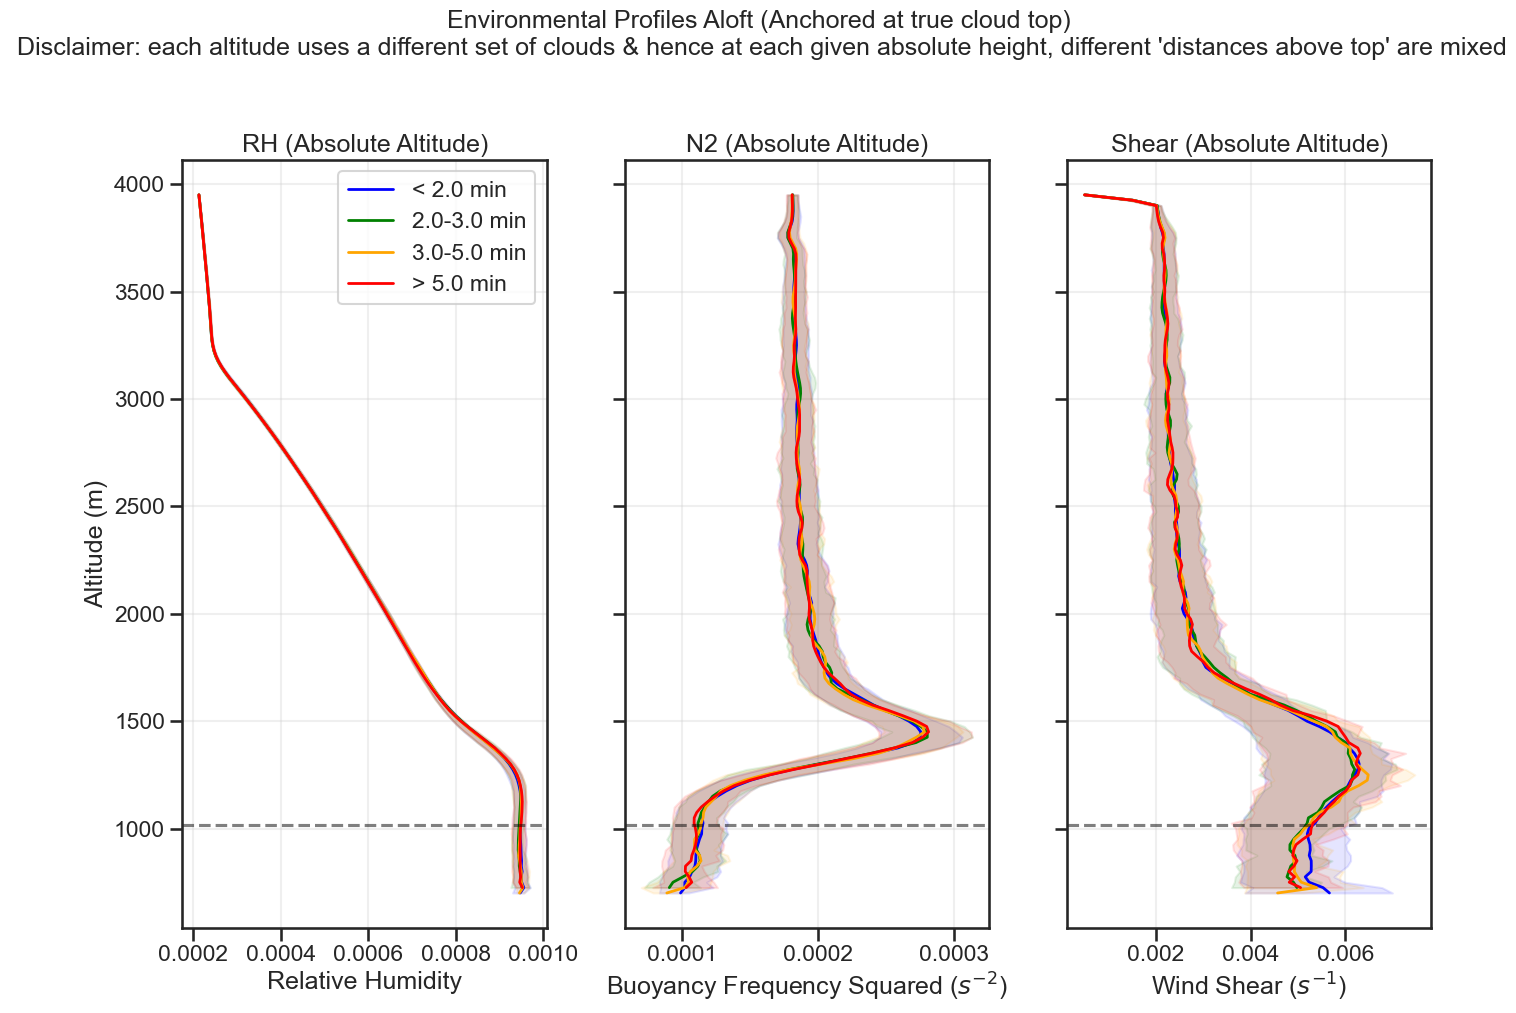

In [8]:
# --- Plot: Profiles in Absolute Altitude (Conditioned on Lifetime) ---
print("--- Plot: Profiles in Absolute Altitude (Conditioned on Lifetime) ---")

# 1. Get Cloud Top Height at Birth
# data['max_height'] is (track, time). We need it at birth_times.
ct_heights = data['max_height'][selected_indices, birth_times]

# 2. Define Absolute Height Grid
# We'll go from 0 to a reasonable max height (e.g. max cloud top + max z_above)
# z_above max is roughly n_levels * dz
max_z_above = np.max(z_above)
max_abs_height = np.nanmax(ct_heights) + max_z_above
# Create grid
z_abs_grid = np.arange(0, max_abs_height + 500, dz)

# 3. Regrid each profile to absolute height
def regrid_profiles(profiles, ct_heights, z_rel, z_grid):
    n_clouds = profiles.shape[0]
    n_grid = len(z_grid)
    regridded = np.full((n_clouds, n_grid), np.nan)
    
    for i in range(n_clouds):
        if np.isnan(ct_heights[i]): continue
        
        # Current absolute heights for this cloud's profile
        z_curr = ct_heights[i] + z_rel
        
        # Values
        vals = profiles[i, :]
        
        # Interpolate
        # Only use valid values
        valid_p = ~np.isnan(vals)
        if np.sum(valid_p) < 2: continue
        
        # np.interp does not handle extrapolation with NaN by default in the way we want (it extends edge values)
        # So we use left=NaN, right=NaN
        interp_vals = np.interp(z_grid, z_curr[valid_p], vals[valid_p], left=np.nan, right=np.nan)
        regridded[i, :] = interp_vals
        
    return regridded

print("Regridding profiles to absolute altitude...")
abs_env_rh = regrid_profiles(sel_env_rh, ct_heights, z_above, z_abs_grid)
abs_env_n2 = regrid_profiles(sel_env_n2, ct_heights, z_above, z_abs_grid)
abs_env_shear = regrid_profiles(sel_env_shear, ct_heights, z_above, z_abs_grid)

# 4. Define Groups (Same as Plot 1)
# Re-defining here to ensure this cell is self-contained if run out of order, 
# but using the same logic as Cell 8.
q1 = np.percentile(sel_lifetime_mins, 25)
q2 = np.percentile(sel_lifetime_mins, 50)
q3 = np.percentile(sel_lifetime_mins, 75)

groups = []
labels = []
colors = ['blue', 'green', 'orange', 'red']

groups.append(sel_lifetime_mins <= q1)
labels.append(f"< {q1:.1f} min")

groups.append((sel_lifetime_mins > q1) & (sel_lifetime_mins <= q2))
labels.append(f"{q1:.1f}-{q2:.1f} min")

groups.append((sel_lifetime_mins > q2) & (sel_lifetime_mins <= q3))
labels.append(f"{q2:.1f}-{q3:.1f} min")

groups.append(sel_lifetime_mins > q3)
labels.append(f"> {q3:.1f} min")

# 5. Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 10), sharey=True)
axes = axes.flatten()

vars_abs = [
    (abs_env_rh, 'Relative Humidity', 'RH (Absolute Altitude)'),
    (abs_env_n2, 'Buoyancy Frequency Squared ($s^{-2}$)', 'N2 (Absolute Altitude)'),
    (abs_env_shear, 'Wind Shear ($s^{-1}$)', 'Shear (Absolute Altitude)')
]

for i, (data_abs, unit_label, title) in enumerate(vars_abs):
    ax = axes[i]
    
    # Iterate over groups
    for j, mask in enumerate(groups):
        if np.sum(mask) == 0: continue
        
        # Subset for this group
        subset = data_abs[mask, :]
        
        # Compute stats ignoring NaNs
        counts = np.sum(~np.isnan(subset), axis=0)
        # Only plot levels with sufficient data
        valid_levels = counts > 5 
        
        if np.sum(valid_levels) > 0:
            mean_prof = np.nanmean(subset, axis=0)
            p25_prof = np.nanpercentile(subset, 25, axis=0)
            p75_prof = np.nanpercentile(subset, 75, axis=0)
            
            # Plot Mean line for this group
            ax.plot(mean_prof[valid_levels], z_abs_grid[valid_levels], color=colors[j], linewidth=2, label=labels[j])
            # Add shaded area for IQR
            ax.fill_betweenx(z_abs_grid[valid_levels], p25_prof[valid_levels], p75_prof[valid_levels], color=colors[j], alpha=0.1)
            
    ax.set_title(title)
    ax.set_xlabel(unit_label)
    if i == 0:
        ax.set_ylabel("Altitude (m)")
        ax.legend()
    ax.grid(True, alpha=0.3)

    # Add mean cloud top height line (global)
    mean_ct = np.nanmean(ct_heights)
    ax.axhline(mean_ct, color='k', linestyle='--', alpha=0.5, label=f'Mean Cloud Top ({mean_ct:.0f}m)')

fig.suptitle("Environmental Profiles Aloft (Anchored at true cloud top)\n Disclaimer: each altitude uses a different set of clouds & hence at each given absolute height, different 'distances above top' are mixed", fontsize=18, y=1.02)

plt.tight_layout()
plt.show()

### Profiles in Absolute Altitude (Restricted Cloud Top Range)
**Physics:** To further isolate the environmental structure, we restrict the analysis to clouds with birth tops within specific altitude ranges (e.g., 700-1000m and 1000-1300m). This ensures we are comparing clouds starting from similar vertical positions.

--- Plot: Profiles in Absolute Altitude (Restricted Cloud Top Ranges) ---

!!! APPLYING TEMPORARY RH FIX (Re-calculating from Mean Profiles) !!!
Note: This adjusts for the unit error in q_t (x1000) and reconstructs RH.
Regridding corrected RH to absolute altitude...
--- FIX APPLIED SUCCESSFULLY ---

Processing Cloud Top Range: 700-1000 m
Regridding corrected RH to absolute altitude...
--- FIX APPLIED SUCCESSFULLY ---

Processing Cloud Top Range: 700-1000 m


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_43999/4114616639.py:156: RuntimeWarning: Mean of empty slice
  mean_prof = np.nanmean(group_data, axis=0)


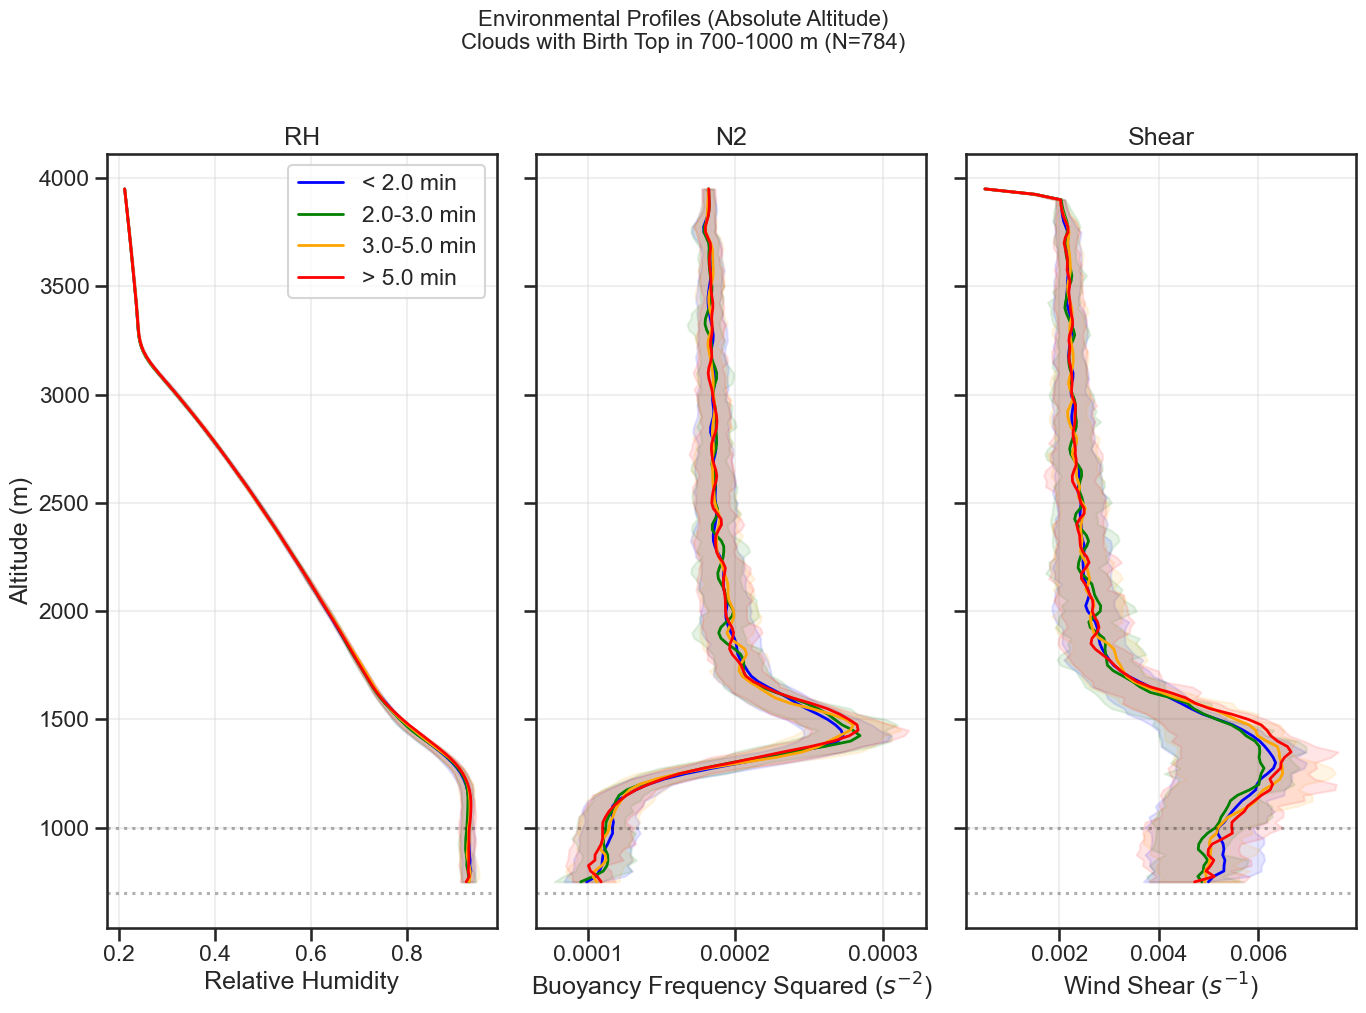


Processing Cloud Top Range: 1000-1300 m


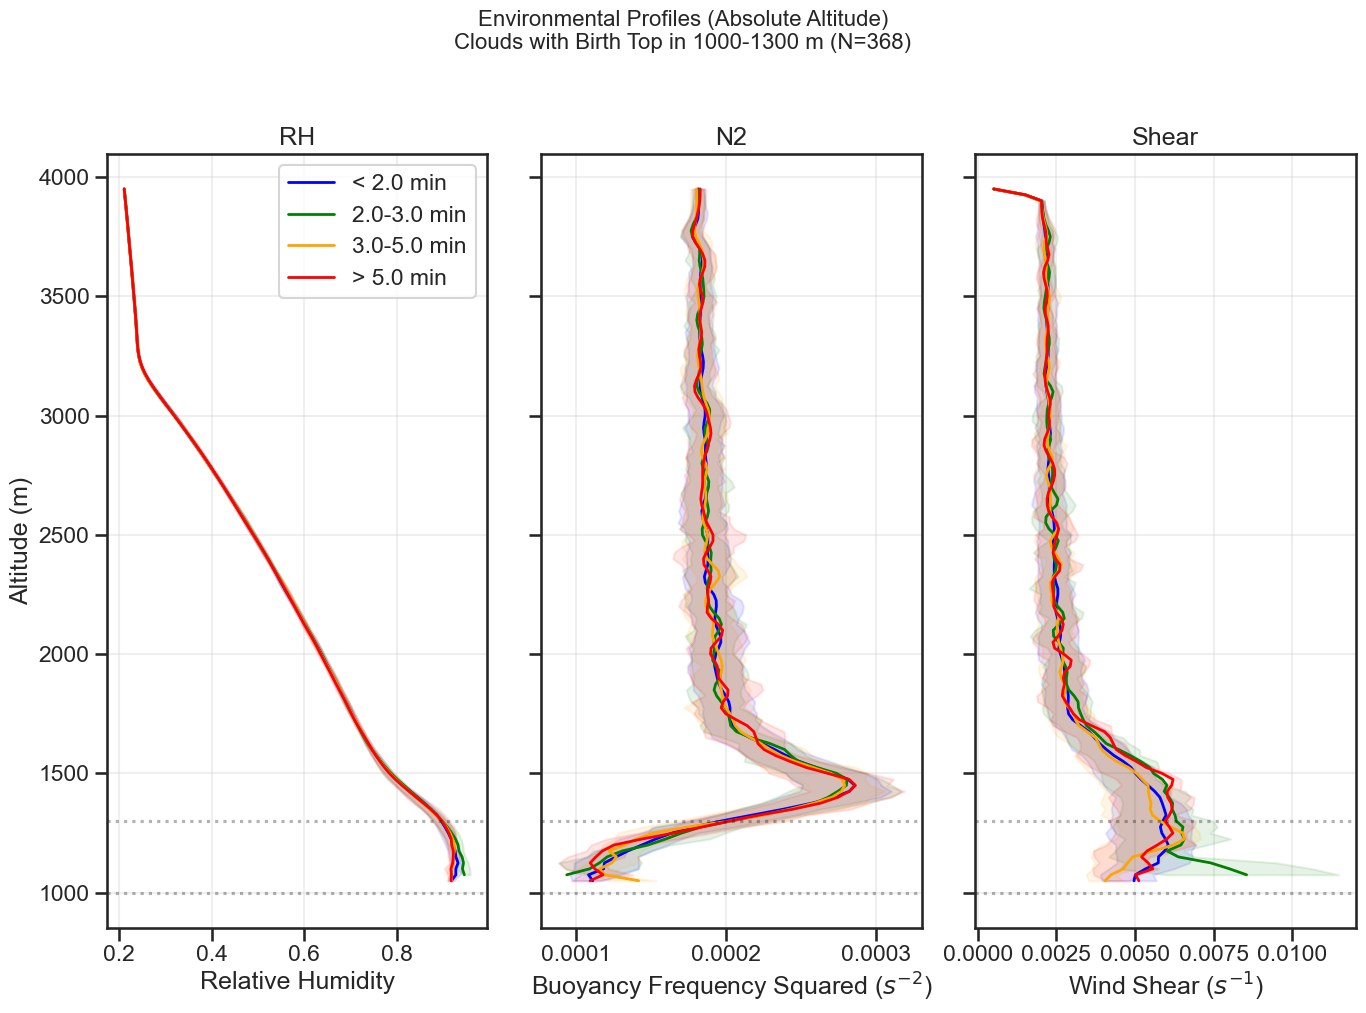

In [9]:
# --- Plot: Profiles in Absolute Altitude (Restricted Cloud Top Ranges) ---
print("--- Plot: Profiles in Absolute Altitude (Restricted Cloud Top Ranges) ---")

# --- TEMPORARY FIX FOR RH CALCULATION (UNIT CORRECTION) ---
print("\n!!! APPLYING TEMPORARY RH FIX (Re-calculating from Mean Profiles) !!!")
print("Note: This adjusts for the unit error in q_t (x1000) and reconstructs RH.")

try:
    # 1. Load Mean Profiles from RICO data (Timestep 0 approximation)
    rico_base = '/Users/jure/PhD/coding/RICO_1hr/'
    mean_profs = {}
    zt_rico = None
    
    # Check if files exist
    import os
    if os.path.exists(rico_base + 'rico.p.nc'):
        for var, fname in [('p', 'rico.p.nc'), ('t', 'rico.t.nc'), ('q', 'rico.q.nc')]:
            with Dataset(f"{rico_base}{fname}", 'r') as ds:
                # Assuming (time, z, y, x) - Take mean over x,y at t=0
                data_slice = ds.variables[var][0, :, :, :]
                mean_profs[var] = np.mean(data_slice, axis=(1, 2))
                if var == 'p':
                    zt_rico = ds.variables['zt'][:]
        
        # 2. Load missing thetal_diff from results (needed for T calculation)
        with Dataset(nc_file, 'r') as ds:
            # Load full array to match indexing
            env_aloft_thetal_diff_all = np.ma.filled(ds.variables['env_aloft_thetal_diff'][:], np.nan)

        # Extract for selected clouds
        sel_thetal_diff = env_aloft_thetal_diff_all[selected_indices, birth_times, :]
        sel_qt_diff = data['env_aloft_qt_diff'][selected_indices, birth_times, :] # Has wrong units (divided by 1000)

        # 3. Reconstruct and Calculate RH
        # Constants
        R_d = 287.04
        c_pd = 1005.0
        c_pv = 1850.0
        p_0 = 100000.0
        epsilon = 0.622

        n_clouds_sel = len(selected_indices)
        n_aloft = len(z_above)
        sel_env_rh_corrected = np.full((n_clouds_sel, n_aloft), np.nan)

        for i in range(n_clouds_sel):
            ct_z = ct_heights[i]
            if np.isnan(ct_z): continue
            
            # Absolute heights of the aloft profile
            z_abs_prof = ct_z + z_above
            
            # Interpolate mean profiles to these heights
            p_env = np.interp(z_abs_prof, zt_rico, mean_profs['p'])
            t_env = np.interp(z_abs_prof, zt_rico, mean_profs['t']) # theta_l
            q_env = np.interp(z_abs_prof, zt_rico, mean_profs['q']) # q_t
            
            # Add anomalies
            # FIX: Multiply qt_diff by 1000 to restore kg/kg units
            q_tot = q_env + (sel_qt_diff[i, :] * 1000.0)
            theta_l = t_env + sel_thetal_diff[i, :]
            
            # Calculate RH
            # T = theta_l * (p/p0)^kappa
            q_v = q_tot # Assuming unsaturated
            kappa = (R_d / c_pd) * ((1 + q_v / epsilon) / (1 + q_v * (c_pv / c_pd)))
            T = theta_l * (p_env / p_0) ** kappa
            
            # es (Magnus formula)
            T_c = T - 273.15
            es = 611.2 * np.exp((17.67 * T_c) / (T_c + 243.5))
            
            # e
            e = (q_v * p_env) / (epsilon + q_v)
            
            rh = e / es
            sel_env_rh_corrected[i, :] = rh

        # 4. Regrid to Absolute Altitude (Overwrite abs_env_rh for this plot)
        print("Regridding corrected RH to absolute altitude...")
        abs_env_rh = regrid_profiles(sel_env_rh_corrected, ct_heights, z_above, z_abs_grid)
        print("--- FIX APPLIED SUCCESSFULLY ---")
        
    else:
        print("WARNING: RICO source files not found. Cannot apply RH fix.")

except Exception as e:
    print(f"ERROR applying RH fix: {e}")
    print("Proceeding with original (likely incorrect) RH values.")
# --- END TEMPORARY FIX ---


# Define height ranges
height_ranges = [(700, 1000), (1000, 1300)]

for h_min, h_max in height_ranges:
    print(f"\nProcessing Cloud Top Range: {h_min}-{h_max} m")
    
    # Filter clouds by birth top height
    range_mask = (ct_heights >= h_min) & (ct_heights < h_max)
    
    if np.sum(range_mask) < 10:
        print(f"  Insufficient clouds in range {h_min}-{h_max}m (N={np.sum(range_mask)}). Skipping.")
        continue
        
    # Subset data for this range
    sub_lifetime = sel_lifetime_mins[range_mask]
    sub_ct_heights = ct_heights[range_mask]
    
    # Subset regridded profiles
    sub_abs_rh = abs_env_rh[range_mask, :]
    sub_abs_n2 = abs_env_n2[range_mask, :]
    sub_abs_shear = abs_env_shear[range_mask, :]
    
    # Define Lifetime Groups for this subset
    # We can use global quartiles or recalculate for this subset. 
    # Using global quartiles allows comparison across plots.
    sub_groups = []
    sub_labels = []
    
    sub_groups.append(sub_lifetime <= q1)
    sub_labels.append(f"< {q1:.1f} min")

    sub_groups.append((sub_lifetime > q1) & (sub_lifetime <= q2))
    sub_labels.append(f"{q1:.1f}-{q2:.1f} min")

    sub_groups.append((sub_lifetime > q2) & (sub_lifetime <= q3))
    sub_labels.append(f"{q2:.1f}-{q3:.1f} min")

    sub_groups.append(sub_lifetime > q3)
    sub_labels.append(f"> {q3:.1f} min")
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(14, 10), sharey=True)
    axes = axes.flatten()

    vars_sub = [
        (sub_abs_rh, 'Relative Humidity', 'RH'),
        (sub_abs_n2, 'Buoyancy Frequency Squared ($s^{-2}$)', 'N2'),
        (sub_abs_shear, 'Wind Shear ($s^{-1}$)', 'Shear')
    ]

    for i, (data_sub, unit_label, title) in enumerate(vars_sub):
        ax = axes[i]
        
        for j, mask in enumerate(sub_groups):
            if np.sum(mask) == 0: continue
            
            # Subset for this group within the height range
            group_data = data_sub[mask, :]
            
            counts = np.sum(~np.isnan(group_data), axis=0)
            valid_levels = counts > 2 # Lower threshold for subsets
            
            if np.sum(valid_levels) > 0:
                mean_prof = np.nanmean(group_data, axis=0)
                p25_prof = np.nanpercentile(group_data, 25, axis=0)
                p75_prof = np.nanpercentile(group_data, 75, axis=0)
                
                ax.plot(mean_prof[valid_levels], z_abs_grid[valid_levels], color=colors[j], linewidth=2, label=sub_labels[j])
                ax.fill_betweenx(z_abs_grid[valid_levels], p25_prof[valid_levels], p75_prof[valid_levels], color=colors[j], alpha=0.1)
        
        ax.set_title(title)
        ax.set_xlabel(unit_label)
        if i == 0:
            ax.set_ylabel("Altitude (m)")
            ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add range bounds
        ax.axhline(h_min, color='k', linestyle=':', alpha=0.3)
        ax.axhline(h_max, color='k', linestyle=':', alpha=0.3)

    fig.suptitle(f"Environmental Profiles (Absolute Altitude)\nClouds with Birth Top in {h_min}-{h_max} m (N={np.sum(range_mask)})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

--- Plot: Anomalies Relative to Population Mean (700-1000m) ---


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_43999/2801424358.py:42: RuntimeWarning: Mean of empty slice
  pop_mean = np.nanmean(data, axis=0)
/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_43999/2801424358.py:49: RuntimeWarning: Mean of empty slice
  group_mean = np.nanmean(data[mask, :], axis=0)


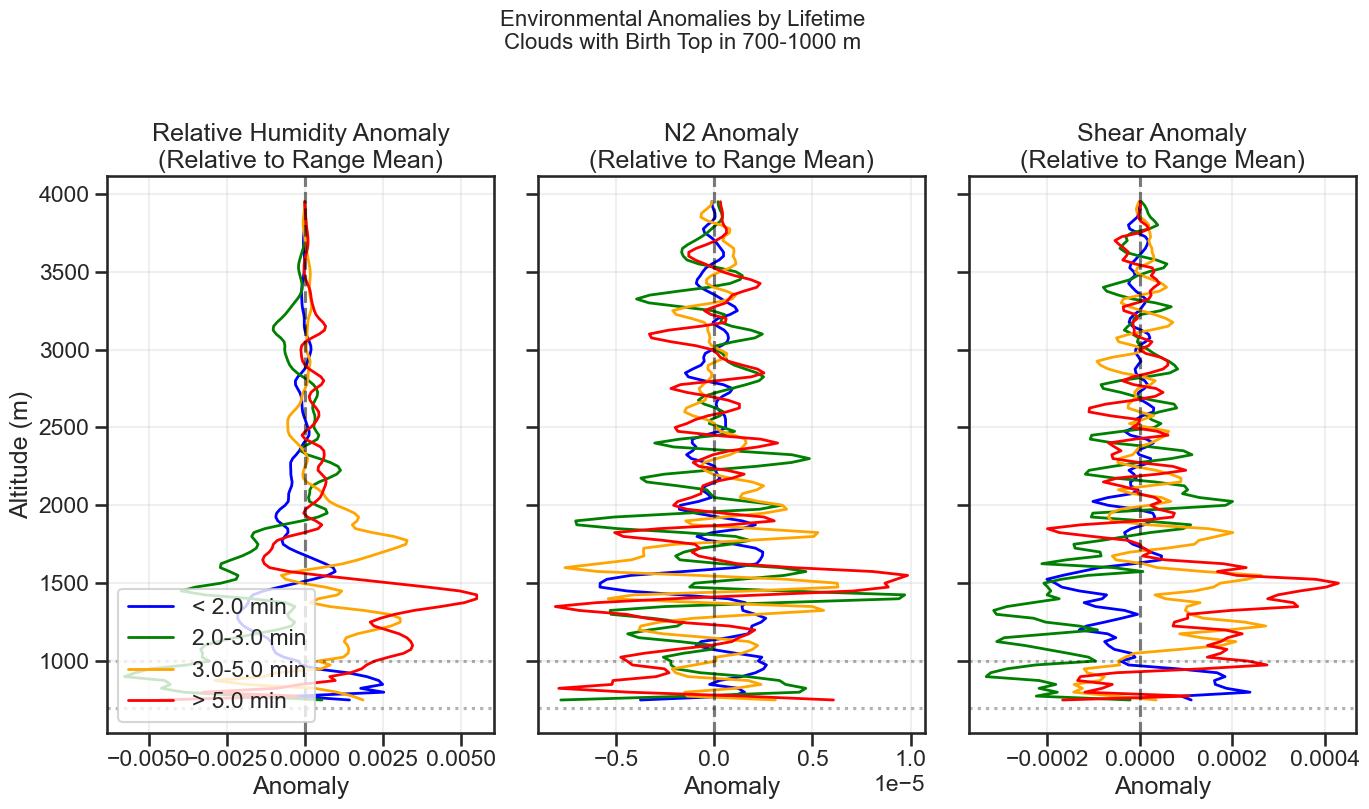

In [10]:
# --- Plot: Anomalies Relative to Population Mean (700-1000m) ---
print("--- Plot: Anomalies Relative to Population Mean (700-1000m) ---")

# Focus on the 700-1000m range as a representative subset
h_min, h_max = 700, 1000
range_mask = (ct_heights >= h_min) & (ct_heights < h_max)

if np.sum(range_mask) < 10:
    print(f"Insufficient data in range {h_min}-{h_max}m.")
else:
    # Subset data
    sub_lifetime = sel_lifetime_mins[range_mask]
    
    # Use the absolute profiles (abs_env_rh might be the corrected one from previous cell)
    sub_data_dict = {
        'Relative Humidity': abs_env_rh[range_mask, :],
        'N2': abs_env_n2[range_mask, :],
        'Shear': abs_env_shear[range_mask, :]
    }
    
    # Define Groups (Quartiles of this specific subset)
    sq1 = np.percentile(sub_lifetime, 25)
    sq2 = np.percentile(sub_lifetime, 50)
    sq3 = np.percentile(sub_lifetime, 75)
    
    sub_groups = [
        (sub_lifetime <= sq1, f"< {sq1:.1f} min"),
        ((sub_lifetime > sq1) & (sub_lifetime <= sq2), f"{sq1:.1f}-{sq2:.1f} min"),
        ((sub_lifetime > sq2) & (sub_lifetime <= sq3), f"{sq2:.1f}-{sq3:.1f} min"),
        (sub_lifetime > sq3, f"> {sq3:.1f} min")
    ]
    colors = ['blue', 'green', 'orange', 'red']
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 8), sharey=True)
    axes = axes.flatten()
    
    for i, (name, data) in enumerate(sub_data_dict.items()):
        ax = axes[i]
        
        # 1. Calculate Population Mean Profile for this height range
        # We use nanmean to handle missing data at different altitudes
        pop_mean = np.nanmean(data, axis=0)
        
        # 2. Plot Quartile Anomalies
        for j, (mask, label) in enumerate(sub_groups):
            if np.sum(mask) == 0: continue
            
            # Group mean
            group_mean = np.nanmean(data[mask, :], axis=0)
            
            # Anomaly: Group Mean - Population Mean
            anomaly = group_mean - pop_mean
            
            # Valid levels for plotting (where we have sufficient data)
            # Filter out levels where the anomaly is NaN or based on too few points
            counts = np.sum(~np.isnan(data[mask, :]), axis=0)
            valid = (counts > 5) & ~np.isnan(anomaly)
            
            ax.plot(anomaly[valid], z_abs_grid[valid], color=colors[j], linewidth=2, label=label)
            
        ax.axvline(0, color='k', linestyle='--', alpha=0.5)
        ax.set_title(f"{name} Anomaly\n(Relative to Range Mean)")
        ax.set_xlabel(f"Anomaly")
        if i == 0:
            ax.set_ylabel("Altitude (m)")
            ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add range bounds
        ax.axhline(h_min, color='k', linestyle=':', alpha=0.3)
        ax.axhline(h_max, color='k', linestyle=':', alpha=0.3)

    fig.suptitle(f"Environmental Anomalies by Lifetime\nClouds with Birth Top in {h_min}-{h_max} m", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

### Layer-Mean Indices vs. Lifetime (Restricted Subset)
**Physics:** To detect weak trends that might be obscured in overlapping profiles, we compute scalar indices for specific layers above the cloud top (e.g., RH in 0-300m, N2 and Shear in 300-1000m) for clouds in the 700-1000m birth-top subset. We then correlate these indices directly with cloud lifetime.

--- Plot: Layer-Mean Indices vs Lifetime (700-1000m Subset) ---


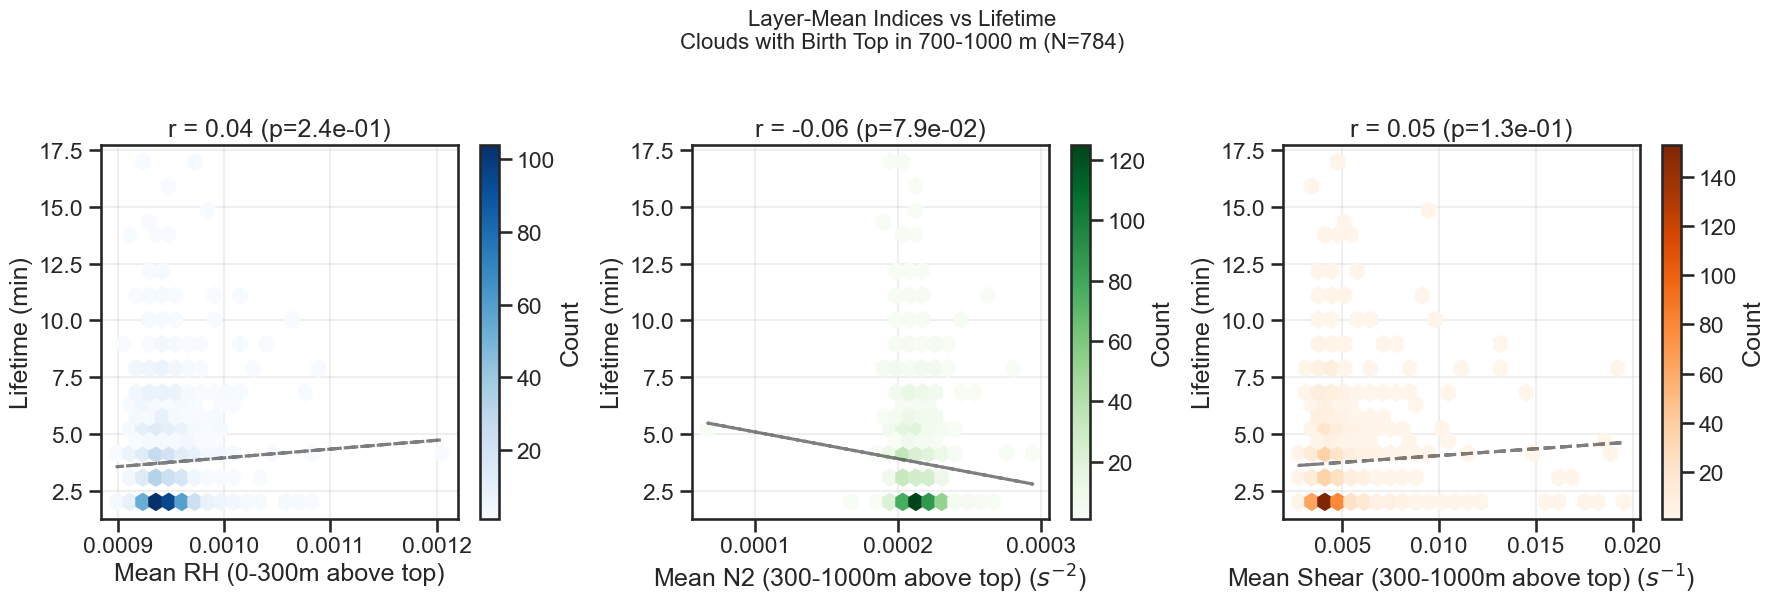

In [11]:
# --- Plot: Layer-Mean Indices vs Lifetime (700-1000m Subset) ---
print("--- Plot: Layer-Mean Indices vs Lifetime (700-1000m Subset) ---")

# 1. Select Subset (700-1000m)
h_min, h_max = 700, 1000
subset_mask = (ct_heights >= h_min) & (ct_heights < h_max)

if np.sum(subset_mask) < 10:
    print(f"Insufficient clouds in range {h_min}-{h_max}m. Skipping.")
else:
    # Extract data for subset
    sub_lifetime = sel_lifetime_mins[subset_mask]
    
    # We need profiles relative to cloud top for this calculation (as requested: "above top")
    # sel_env_rh is (N, n_levels) where levels are z_above
    sub_rh_prof = sel_env_rh[subset_mask, :]
    sub_n2_prof = sel_env_n2[subset_mask, :]
    sub_shear_prof = sel_env_shear[subset_mask, :]
    
    # 2. Compute Indices
    # RH 0-300m above top
    mask_0_300 = (z_above >= 0) & (z_above <= 300)
    rh_0_300 = np.nanmean(sub_rh_prof[:, mask_0_300], axis=1)
    
    # N2 and Shear 300-1000m above top
    mask_300_1000 = (z_above > 300) & (z_above <= 1000)
    n2_300_1000 = np.nanmean(sub_n2_prof[:, mask_300_1000], axis=1)
    shear_300_1000 = np.nanmean(sub_shear_prof[:, mask_300_1000], axis=1)
    
    # 3. Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes = axes.flatten()
    
    plot_data = [
        (rh_0_300, "Mean RH (0-300m above top)", "Blues"),
        (n2_300_1000, "Mean N2 (300-1000m above top) ($s^{-2}$)", "Greens"),
        (shear_300_1000, "Mean Shear (300-1000m above top) ($s^{-1}$)", "Oranges")
    ]
    
    for i, (x_data, x_label, cmap) in enumerate(plot_data):
        ax = axes[i]
        y_data = sub_lifetime
        
        # Remove NaNs
        valid = ~np.isnan(x_data) & ~np.isnan(y_data)
        x_clean = x_data[valid]
        y_clean = y_data[valid]
        
        if len(x_clean) > 2:
            # Calculate correlation
            r, p = pearsonr(x_clean, y_clean)
            
            # Hexbin plot
            hb = ax.hexbin(x_clean, y_clean, gridsize=25, cmap=cmap, mincnt=1)
            cb = plt.colorbar(hb, ax=ax)
            cb.set_label('Count')
            
            # Add trend line
            m, b = np.polyfit(x_clean, y_clean, 1)
            ax.plot(x_clean, m*x_clean + b, 'k--', alpha=0.5, label=f'Trend')
            
            ax.set_title(f"r = {r:.2f} (p={p:.1e})")
        else:
            ax.text(0.5, 0.5, "Insufficient Data", ha='center')
            
        ax.set_xlabel(x_label)
        ax.set_ylabel("Lifetime (min)")
        ax.grid(True, alpha=0.3)
        
    fig.suptitle(f"Layer-Mean Indices vs Lifetime\nClouds with Birth Top in {h_min}-{h_max} m (N={len(sub_lifetime)})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

### Profiles vs. Max Height
**Physics:** Growth potential. Does the local environment above the cloud top determine which shallow clouds deepen vs. those that remain stunted?

--- Plot 2: Profiles conditioned on Max Height (Total N=1669) ---


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_43999/1986419811.py:52: RuntimeWarning: Mean of empty slice
  mean_prof = np.nanmean(subset, axis=0)


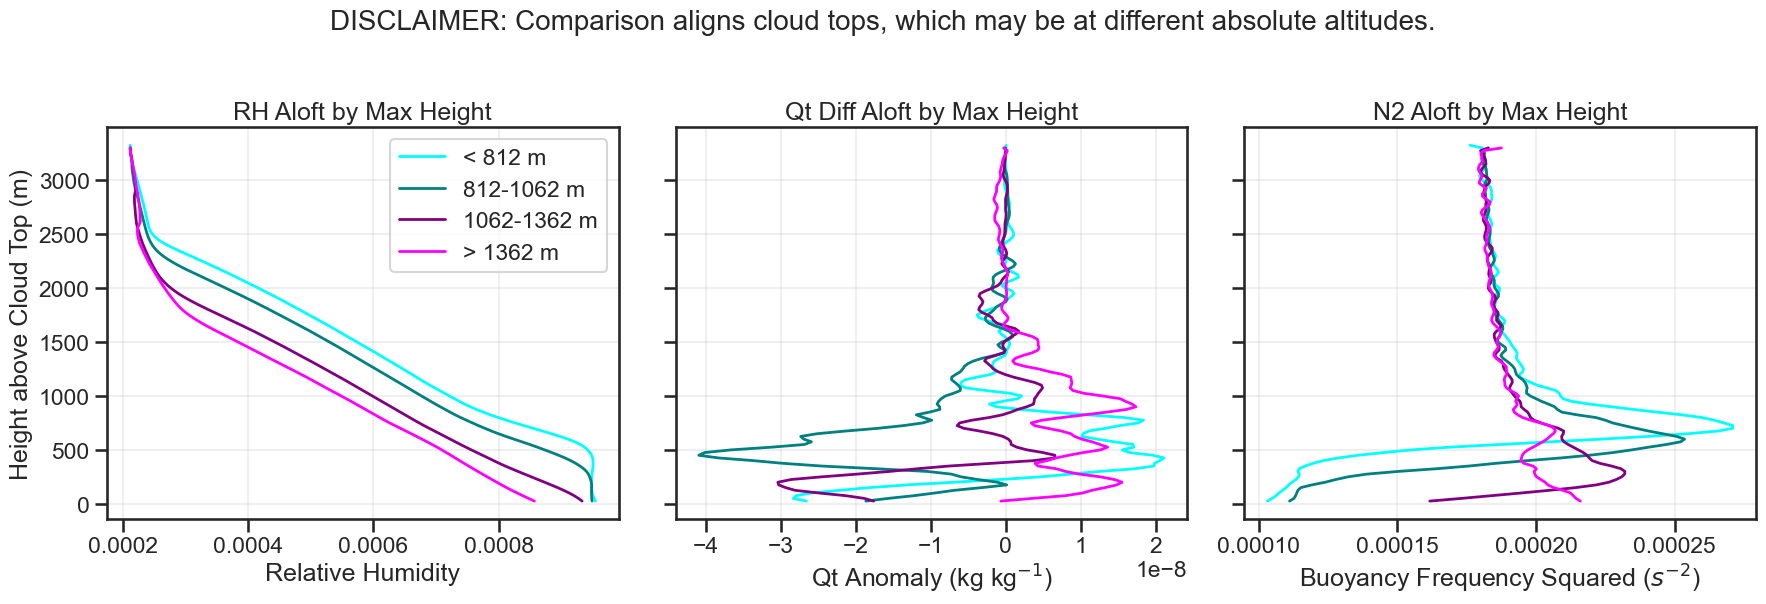

In [12]:
# --- Plot 2: Profiles conditioned on Max Height ---

if len(sel_max_height) == 0:
    print("No clouds selected. Skipping plot.")
else:
    print(f"--- Plot 2: Profiles conditioned on Max Height (Total N={len(sel_max_height)}) ---")

# Define groups by quartiles of max height
h_q1 = np.percentile(sel_max_height, 25)
h_q2 = np.percentile(sel_max_height, 50)
h_q3 = np.percentile(sel_max_height, 75)

h_groups = []
h_labels = []
h_colors = ['cyan', 'teal', 'purple', 'magenta']

# Group 1: Shallow
mask1 = sel_max_height <= h_q1
h_groups.append(mask1)
h_labels.append(f"< {h_q1:.0f} m")

# Group 2: Medium-Shallow
mask2 = (sel_max_height > h_q1) & (sel_max_height <= h_q2)
h_groups.append(mask2)
h_labels.append(f"{h_q1:.0f}-{h_q2:.0f} m")

# Group 3: Medium-Deep
mask3 = (sel_max_height > h_q2) & (sel_max_height <= h_q3)
h_groups.append(mask3)
h_labels.append(f"{h_q2:.0f}-{h_q3:.0f} m")

# Group 4: Deep
mask4 = sel_max_height > h_q3
h_groups.append(mask4)
h_labels.append(f"> {h_q3:.0f} m")

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
axes = axes.flatten()

# Plot only RH, Qt Diff, N2 as requested
vars_to_plot = ['RH Aloft', 'Qt Diff Aloft', 'N2 Aloft']

for i, var_name in enumerate(vars_to_plot):
    ax = axes[i]
    # Use variable_info from previous cell
    var_data, unit_label = variable_info[var_name]
    
    for j, mask in enumerate(h_groups):
        if np.sum(mask) == 0: continue
        
        subset = var_data[mask, :]
        mean_prof = np.nanmean(subset, axis=0)
        
        ax.plot(mean_prof, z_above, label=h_labels[j], color=h_colors[j], linewidth=2)
        
    ax.set_title(f"{var_name} by Max Height")
    ax.set_xlabel(unit_label)
    if i == 0:
        ax.set_ylabel("Height above Cloud Top (m)")
        ax.legend() 
    ax.grid(True, alpha=0.3)

fig.suptitle("DISCLAIMER: Comparison aligns cloud tops, which may be at different absolute altitudes.", fontsize=20, y=1.02)

plt.tight_layout()
plt.show()

### Growth vs. Birth Height (Colored by Environment)
**Physics:** This plot relates cloud growth to the environmental conditions aloft at birth.
*   **X-axis:** Cloud Top Height at Birth ($z_{top, birth}$)
*   **Y-axis:** Vertical Growth ($z_{top, max} - z_{top, birth}$)
*   **Point Size:** Cloud Lifetime (larger points = longer lived)
*   **Color:** Environmental Index Aloft
    *   **Left Panel:** Mean RH (0-300m above top).
    *   **Right Panel:** Mean $N^2$ (300-1000m above top).

This visualizes whether clouds that grow deep (high Y) or live long (large points) are those born into favorable environments (moist/unstable), controlling for their starting position (X).
Contours indicate the density of the cloud population in this phase space.

--- Plot: Growth vs Birth Height (Colored by Environment) ---


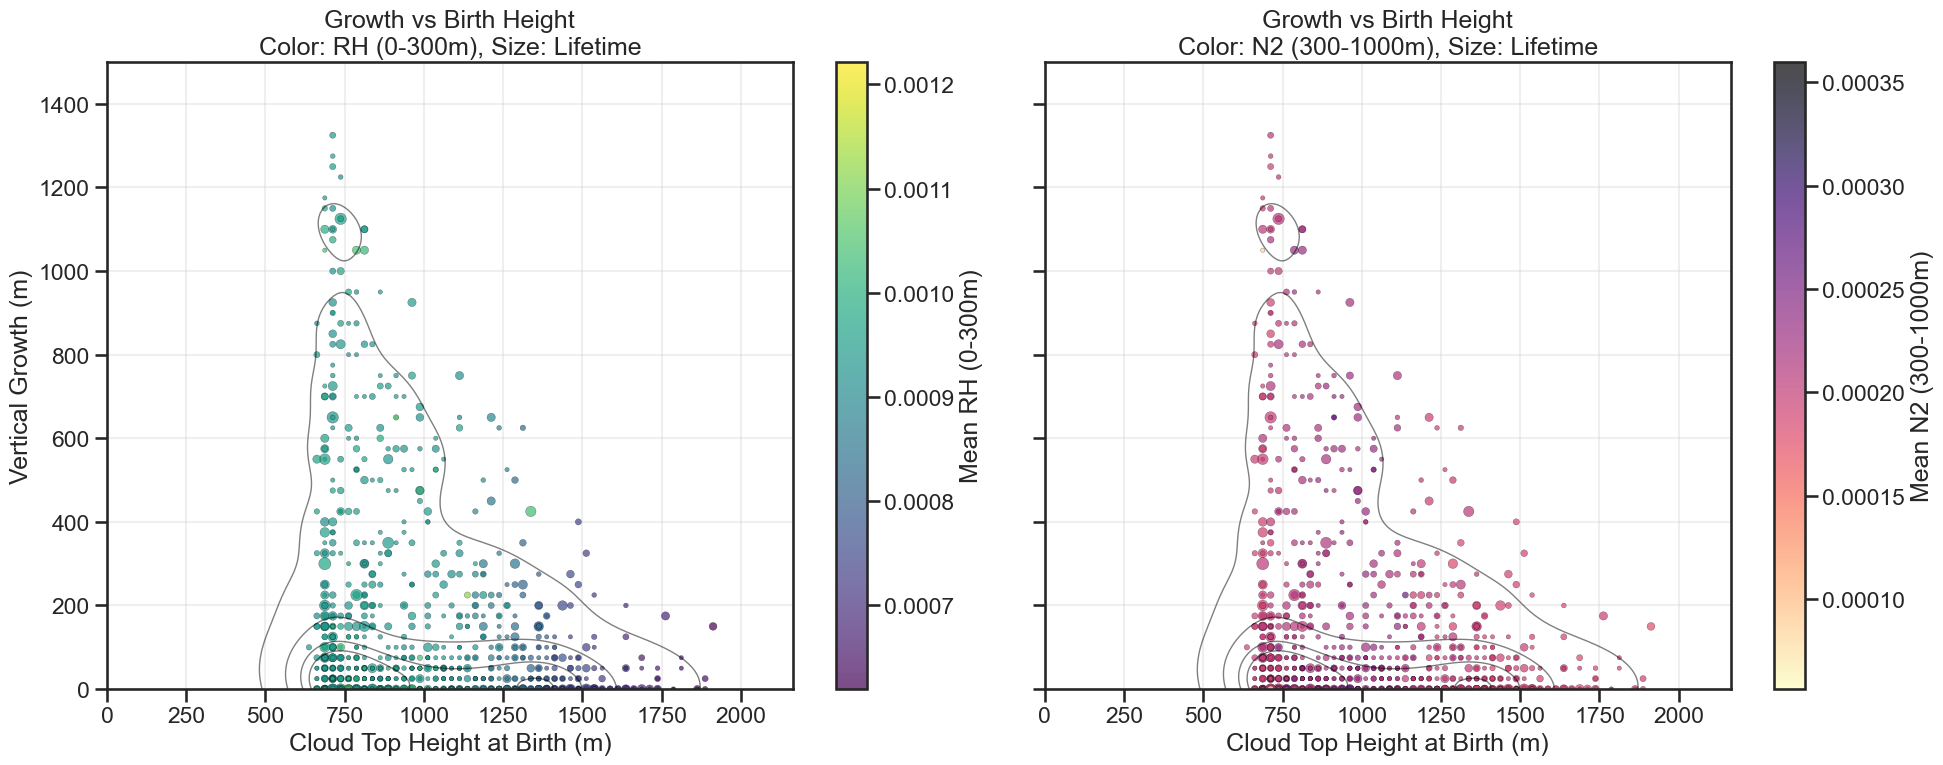

In [13]:
# --- Plot: Growth vs Birth Height (Colored by Environment) ---
print("--- Plot: Growth vs Birth Height (Colored by Environment) ---")

# 1. Prepare Data
# Ensure ct_heights is available
if 'ct_heights' not in locals():
    ct_heights = data['max_height'][selected_indices, birth_times]

growth = sel_max_height - ct_heights

# Calculate Indices
# RH 0-300m above top
mask_0_300 = (z_above >= 0) & (z_above <= 300)
rh_0_300 = np.nanmean(sel_env_rh[:, mask_0_300], axis=1)

# N2 300-1000m above top
mask_300_1000 = (z_above > 300) & (z_above <= 1000)
n2_300_1000 = np.nanmean(sel_env_n2[:, mask_300_1000], axis=1)

# 2. Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Configuration
# (Data, Label, Colormap, Title Variable, Min/Max for Color scaling)
plots = [
    (rh_0_300, 'Mean RH (0-300m)', 'viridis', 'RH (0-300m)'), 
    (n2_300_1000, 'Mean N2 (300-1000m)', 'magma_r', 'N2 (300-1000m)') 
]

for i, (c_data, c_label, cmap, title_var) in enumerate(plots):
    ax = axes[i]
    
    # Scatter: Size ~ Lifetime
    # Scale size: min 10, max 200 based on lifetime
    # Assuming lifetime 0-60 mins roughly
    sizes = np.clip(sel_lifetime_mins * 4, 10, 250)
    
    # Handle NaNs in color data
    valid_c = ~np.isnan(c_data)
    
    sc = ax.scatter(ct_heights[valid_c], growth[valid_c], c=c_data[valid_c], s=sizes[valid_c], 
                    cmap=cmap, alpha=0.7, edgecolors='k', linewidth=0.2)
    
    # Add Density Contours (using all valid geometry data)
    valid_geom = ~np.isnan(ct_heights) & ~np.isnan(growth)
    if np.sum(valid_geom) > 10:
        sns.kdeplot(x=ct_heights[valid_geom], y=growth[valid_geom], 
                    ax=ax, levels=5, color='k', linewidths=1.0, alpha=0.5)
        
    # Colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(c_label)
    
    ax.set_xlabel('Cloud Top Height at Birth (m)')
    if i == 0:
        ax.set_ylabel('Vertical Growth (m)')
    
    ax.set_title(f'Growth vs Birth Height\nColor: {title_var}, Size: Lifetime')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

### Layer Indices vs. Outcomes
**Physics:** Layer-mean impacts. Tests if specific layers (e.g., immediate entrainment zone 0-300m) dictate cloud fate.

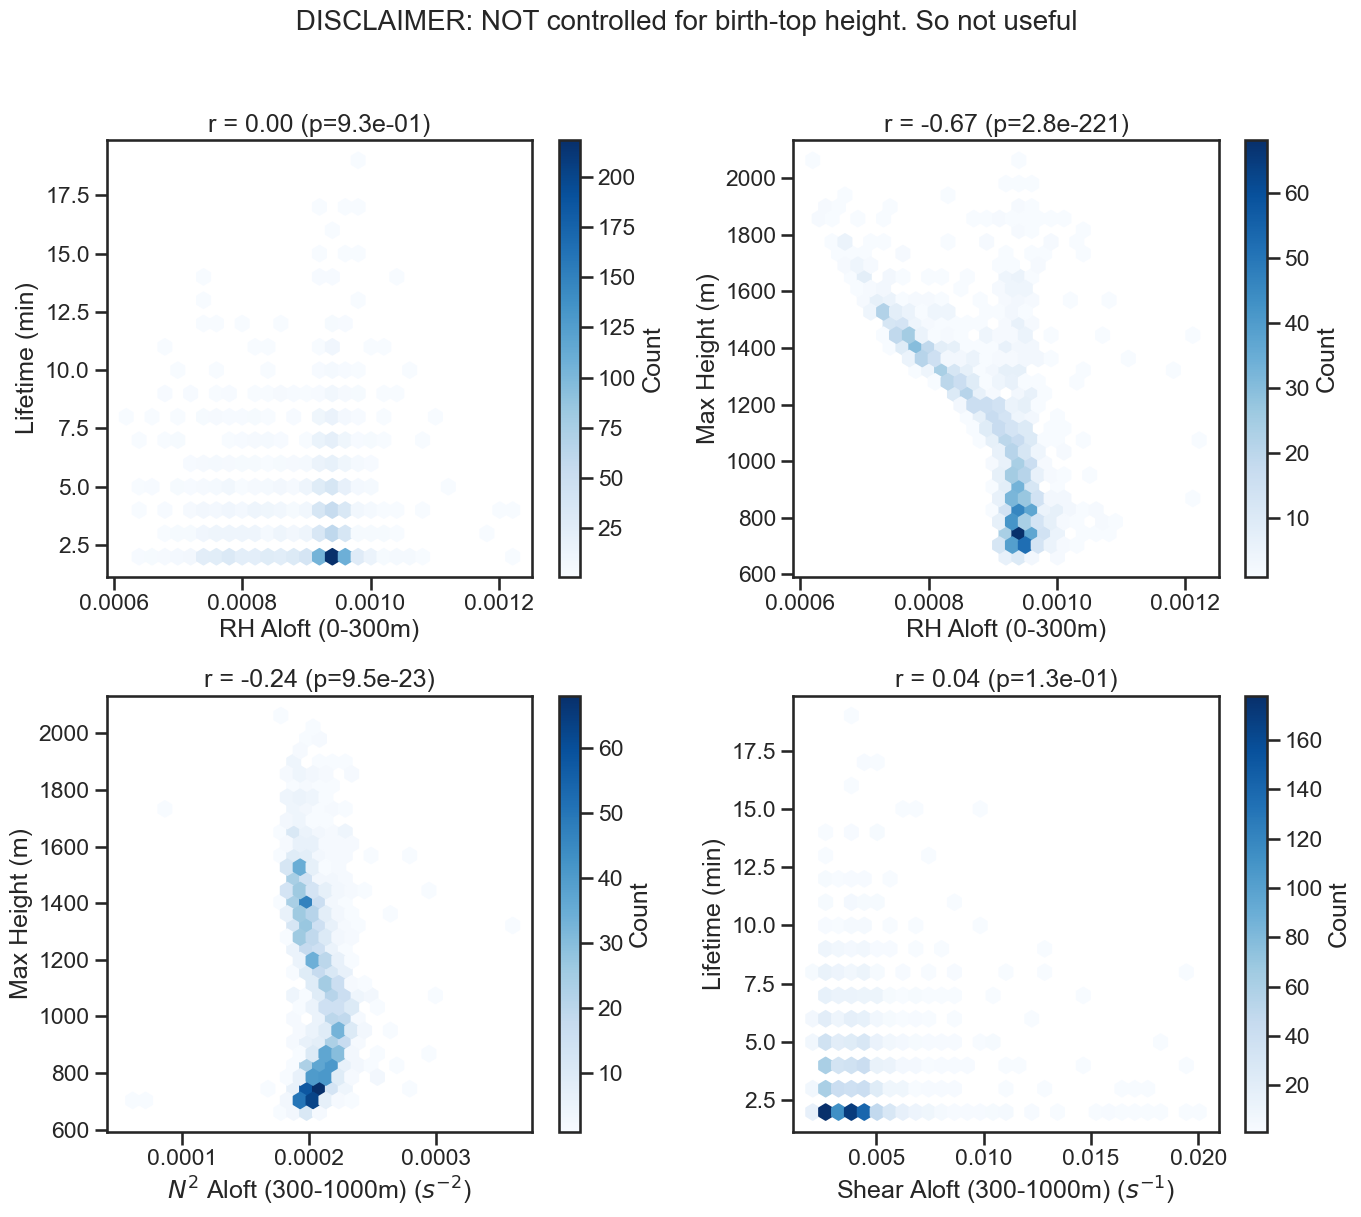

In [14]:
# --- Plot 3: Simple Layer Indices vs Age / Height ---

# Define layers
# 0-300m
mask_0_300 = (z_above >= 0) & (z_above <= 300)
# 300-1000m
mask_300_1000 = (z_above > 300) & (z_above <= 1000)

# Compute scalar indices
rh_aloft_0_300 = np.nanmean(sel_env_rh[:, mask_0_300], axis=1)
qt_diff_aloft_0_300 = np.nanmean(sel_env_qt[:, mask_0_300], axis=1)
n2_aloft_300_1000 = np.nanmean(sel_env_n2[:, mask_300_1000], axis=1)
shear_aloft_300_1000 = np.nanmean(sel_env_shear[:, mask_300_1000], axis=1)

# Define pairs to plot with physical units
pairs = [
    (rh_aloft_0_300, sel_lifetime_mins, "RH Aloft (0-300m)", "Lifetime (min)"),
    (rh_aloft_0_300, sel_max_height, "RH Aloft (0-300m)", "Max Height (m)"),
    (n2_aloft_300_1000, sel_max_height, "$N^2$ Aloft (300-1000m) ($s^{-2}$)", "Max Height (m)"),
    (shear_aloft_300_1000, sel_lifetime_mins, "Shear Aloft (300-1000m) ($s^{-1}$)", "Lifetime (min)")
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (x_data, y_data, x_label, y_label) in enumerate(pairs):
    ax = axes[i]
    
    # Remove NaNs for correlation
    valid = ~np.isnan(x_data) & ~np.isnan(y_data)
    x_clean = x_data[valid]
    y_clean = y_data[valid]
    
    if len(x_clean) > 1:
        corr, p_val = pearsonr(x_clean, y_clean)
        
        # 2D Histogram / Scatter
        # Using hexbin for density
        hb = ax.hexbin(x_clean, y_clean, gridsize=30, cmap='Blues', mincnt=1)
        cb = plt.colorbar(hb, ax=ax)
        cb.set_label('Count')
        
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(f"r = {corr:.2f} (p={p_val:.1e})")
    else:
        ax.text(0.5, 0.5, "Insufficient Data", ha='center', va='center')

fig.suptitle(" DISCLAIMER: NOT controlled for birth-top height. So not useful", fontsize=20, y=1.02)
       

plt.tight_layout()
plt.show()

### Correlation Vertical Structure
**Physics:** Vertical sensitivity. Pinpoints the height above cloud top where environmental anomalies most strongly predict lifetime or depth.

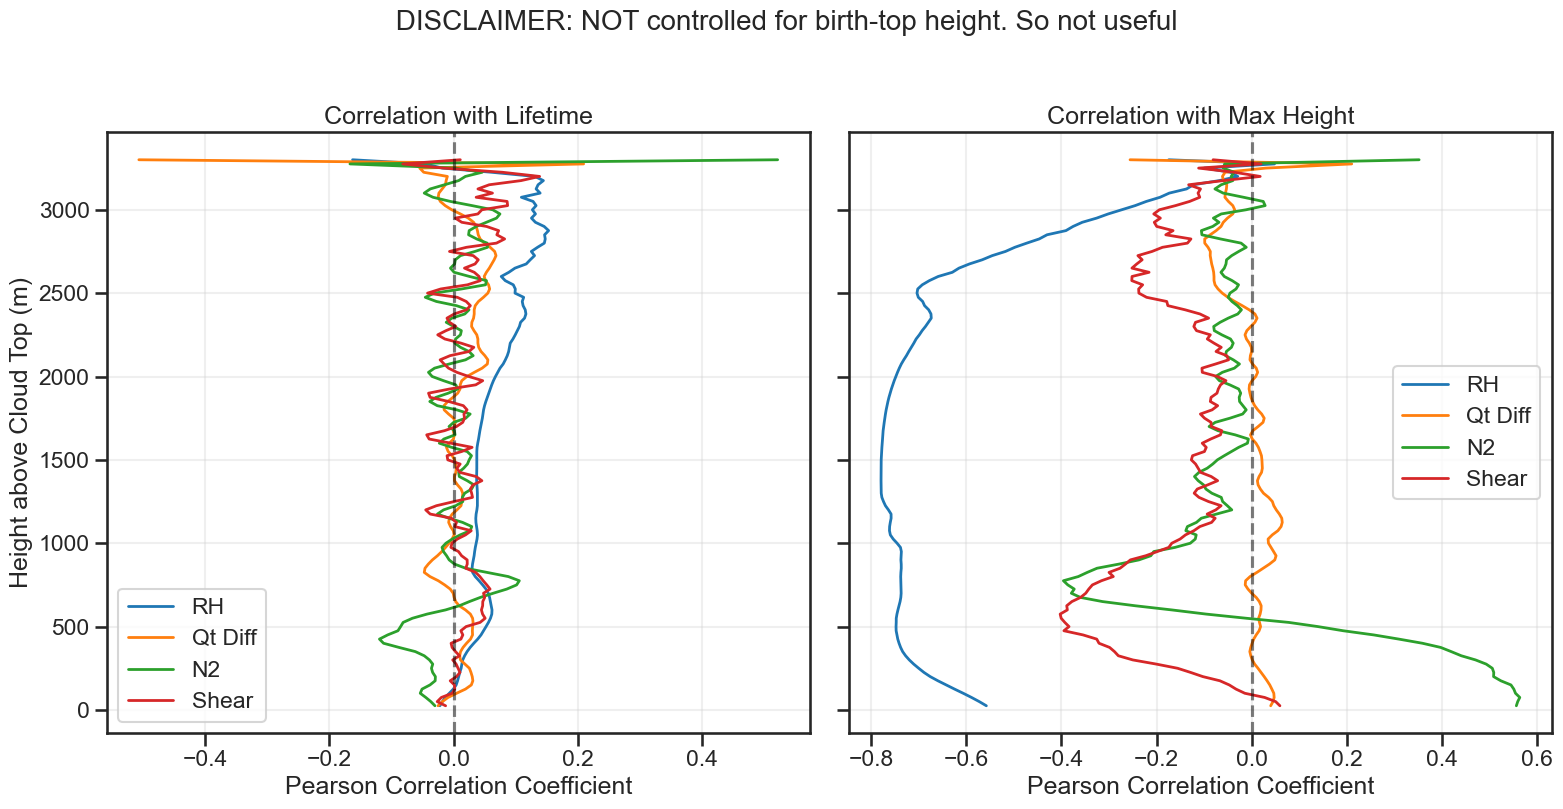

In [15]:
# --- Plot 4: Correlation vs Height ---

# Compute correlation for each level
def compute_profile_correlation(profile_data, outcome_data):
    corrs = []
    for k in range(profile_data.shape[1]):
        x = profile_data[:, k]
        y = outcome_data
        valid = ~np.isnan(x) & ~np.isnan(y)
        if np.sum(valid) > 2:
            r, _ = pearsonr(x[valid], y[valid])
            corrs.append(r)
        else:
            corrs.append(np.nan)
    return np.array(corrs)

# Correlations with Lifetime
corr_rh_life = compute_profile_correlation(sel_env_rh, sel_lifetime_mins)
corr_qt_life = compute_profile_correlation(sel_env_qt, sel_lifetime_mins)
corr_n2_life = compute_profile_correlation(sel_env_n2, sel_lifetime_mins)
corr_shear_life = compute_profile_correlation(sel_env_shear, sel_lifetime_mins)

# Correlations with Max Height
corr_rh_height = compute_profile_correlation(sel_env_rh, sel_max_height)
corr_qt_height = compute_profile_correlation(sel_env_qt, sel_max_height)
corr_n2_height = compute_profile_correlation(sel_env_n2, sel_max_height)
corr_shear_height = compute_profile_correlation(sel_env_shear, sel_max_height)

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot Lifetime Correlations
ax = axes[0]
ax.plot(corr_rh_life, z_above, label='RH', linewidth=2)
ax.plot(corr_qt_life, z_above, label='Qt Diff', linewidth=2)
ax.plot(corr_n2_life, z_above, label='N2', linewidth=2)
ax.plot(corr_shear_life, z_above, label='Shear', linewidth=2)
ax.axvline(0, color='k', linestyle='--', alpha=0.5)
ax.set_title("Correlation with Lifetime")
ax.set_xlabel("Pearson Correlation Coefficient")
ax.set_ylabel("Height above Cloud Top (m)")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot Max Height Correlations
ax = axes[1]
ax.plot(corr_rh_height, z_above, label='RH', linewidth=2)
ax.plot(corr_qt_height, z_above, label='Qt Diff', linewidth=2)
ax.plot(corr_n2_height, z_above, label='N2', linewidth=2)
ax.plot(corr_shear_height, z_above, label='Shear', linewidth=2)
ax.axvline(0, color='k', linestyle='--', alpha=0.5)
ax.set_title("Correlation with Max Height")
ax.set_xlabel("Pearson Correlation Coefficient")
ax.legend()
ax.grid(True, alpha=0.3)

fig.suptitle(" DISCLAIMER: NOT controlled for birth-top height. So not useful", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()